# 0. Ambiente

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Leitura

In [60]:
df_capacidade_geracao = pd.read_parquet('../../data/external/ONS/capacidade_geracao/capacidade_geracao.parquet')

# 2. Preprocessamento

## 2.1. Tipagem e características da tabela

In [61]:
df_capacidade_geracao.head()

,id_subsistema,nom_subsistema,id_estado,nom_estado,nom_modalidadeoperacao,nom_agenteproprietario,nom_tipousina,nom_usina,ceg,nom_unidadegeradora,cod_equipamento,num_unidadegeradora,nom_combustivel,dat_entradateste,dat_entradaoperacao,dat_desativacao,val_potenciaefetiva
0,NE,NORDESTE,AL,ALAGOAS,TIPO I,CHESF,HIDROELÉTRICA,XINGÓ,UHE.PH.SE.027053-9.01,UG 527 MW USINA XINGO 6 AL,ALUXG-0UG6,6,HIDRÁULICA,1994-04-30,1994-04-30,,527.0
1,NE,NORDESTE,AL,ALAGOAS,TIPO I,CHESF,HIDROELÉTRICA,XINGÓ,UHE.PH.SE.027053-9.01,UG 527 MW USINA XINGO 5 AL,ALUXG-0UG5,5,HIDRÁULICA,1995-01-31,1995-01-31,,527.0
2,NE,NORDESTE,AL,ALAGOAS,TIPO I,CHESF,HIDROELÉTRICA,XINGÓ,UHE.PH.SE.027053-9.01,UG 527 MW USINA XINGO 4 AL,ALUXG-0UG4,4,HIDRÁULICA,1995-10-26,1995-10-26,,527.0
3,NE,NORDESTE,AL,ALAGOAS,TIPO I,CHESF,HIDROELÉTRICA,XINGÓ,UHE.PH.SE.027053-9.01,UG 527 MW USINA XINGO 3 AL,ALUXG-0UG3,3,HIDRÁULICA,1996-07-31,1996-07-31,,527.0
4,NE,NORDESTE,AL,ALAGOAS,TIPO I,CHESF,HIDROELÉTRICA,XINGÓ,UHE.PH.SE.027053-9.01,UG 527 MW USINA XINGO 2 AL,ALUXG-0UG2,2,HIDRÁULICA,1996-12-20,1996-12-20,,527.0


In [62]:
print(f"""Tipo de dados:
{df_capacidade_geracao.dtypes}

Colunas:
{df_capacidade_geracao.columns}

Formato:
{df_capacidade_geracao.shape}

Nulos:
{df_capacidade_geracao.isnull().sum()}
""")

Tipo de dados:
id_subsistema              object
nom_subsistema             object
id_estado                  object
nom_estado                 object
nom_modalidadeoperacao     object
nom_agenteproprietario     object
nom_tipousina              object
nom_usina                  object
ceg                        object
nom_unidadegeradora        object
cod_equipamento            object
num_unidadegeradora        object
nom_combustivel            object
dat_entradateste           object
dat_entradaoperacao        object
dat_desativacao            object
val_potenciaefetiva       float64
dtype: object

Colunas:
Index(['id_subsistema', 'nom_subsistema', 'id_estado', 'nom_estado',
       'nom_modalidadeoperacao', 'nom_agenteproprietario', 'nom_tipousina',
       'nom_usina', 'ceg', 'nom_unidadegeradora', 'cod_equipamento',
       'num_unidadegeradora', 'nom_combustivel', 'dat_entradateste',
       'dat_entradaoperacao', 'dat_desativacao', 'val_potenciaefetiva'],
      dtype='object')

Form

In [63]:
# Corrigindo tipo de dado segundo documentação
string_cols = [
    'id_subsistema', 'nom_subsistema', 'id_estado', 'nom_estado', 'nom_modalidadeoperacao', 'nom_agenteproprietario', 'nom_tipousina',
    'nom_usina', 'ceg', 'nom_unidadegeradora', 'cod_equipamento', 'num_unidadegeradora', 'nom_combustivel',
]

datetime_cols = ['dat_entradateste', 'dat_entradaoperacao', 'dat_desativacao']

df_capacidade_geracao[string_cols] = df_capacidade_geracao[string_cols].astype(str)
df_capacidade_geracao[datetime_cols] = df_capacidade_geracao[datetime_cols].apply(pd.to_datetime)

In [64]:
# Embora não tenham dados nulos, dada existência de dados vazios nas datas inexistentes,
# registros nulos (NaT) são gerados
df_capacidade_geracao[datetime_cols].isnull().sum()

dat_entradateste         12
dat_entradaoperacao       0
dat_desativacao        4106
dtype: int64

## 2.2. Usinas com fontes renováveis ativas

In [132]:
# Filtrando unidades geradores ativas e comissionadas (condições de operação verificadas)
df_capacidade_geracao_ativa = df_capacidade_geracao[
    df_capacidade_geracao['dat_desativacao'].isnull()
    & df_capacidade_geracao['dat_entradateste'].notnull()
]

# Filtrando energias renováveis
df_capacidade_geracao_ativa = df_capacidade_geracao_ativa[
    df_capacidade_geracao_ativa['nom_combustivel'].isin(
        ['HIDRÁULICA', 'EÓLICA', 'FOTOVOLTAICA', 'NUCLEAR'])
]

print(df_capacidade_geracao.shape, df_capacidade_geracao_ativa.shape)

(5064, 17) (3619, 17)


## 2.3. Geração em MWh

In [136]:
"""
Considerando que:
    Todas as usinas operam com 90% de sua capacidade;
    Usinas fotovoltaicas operam apenas 12h/dia (Apenas quando há sol).
"""

df_capacidade_geracao_ativa['potencia_mwh'] = np.where(
    df_capacidade_geracao_ativa['nom_combustivel'] == 'FOTOVOLTAICA',
    df_capacidade_geracao_ativa['val_potenciaefetiva'] * 12 * .9,
    df_capacidade_geracao_ativa['val_potenciaefetiva'] * 24 * .9
)

# 3. Agregando informações por usina

In [137]:
df_capacidade_usina = df_capacidade_geracao_ativa.groupby(
    [
        'ceg', 'nom_combustivel', 'nom_agenteproprietario',
        'nom_estado', 'id_estado', 'nom_subsistema', 'id_subsistema'
    ], as_index=False
).agg(
    unidades_geradoras = ('num_unidadegeradora', 'count'),
    potencia_nominal_mw = ('val_potenciaefetiva', 'sum'),
    potencia_mwh = ('potencia_mwh', 'sum')
)

In [138]:
df_capacidade_tipo_uf = df_capacidade_usina.groupby(
    ['id_estado', 'nom_estado', 'nom_combustivel'], as_index=False
)[['unidades_geradoras', 'potencia_nominal_mw', 'potencia_mwh']].sum()

df_capacidade_tipo_subsist = df_capacidade_usina.groupby(
    ['id_subsistema', 'nom_subsistema', 'nom_combustivel'], as_index=False
)[['unidades_geradoras', 'potencia_nominal_mw', 'potencia_mwh']].sum()

df_capacidade_tipo_agente = df_capacidade_usina.groupby(
    ['nom_agenteproprietario', 'nom_combustivel'], as_index=False
)[['unidades_geradoras', 'potencia_nominal_mw', 'potencia_mwh']].sum()

# 4. Visualização

## 4.1. Capacidade de geração por usina, Estado e subsistema

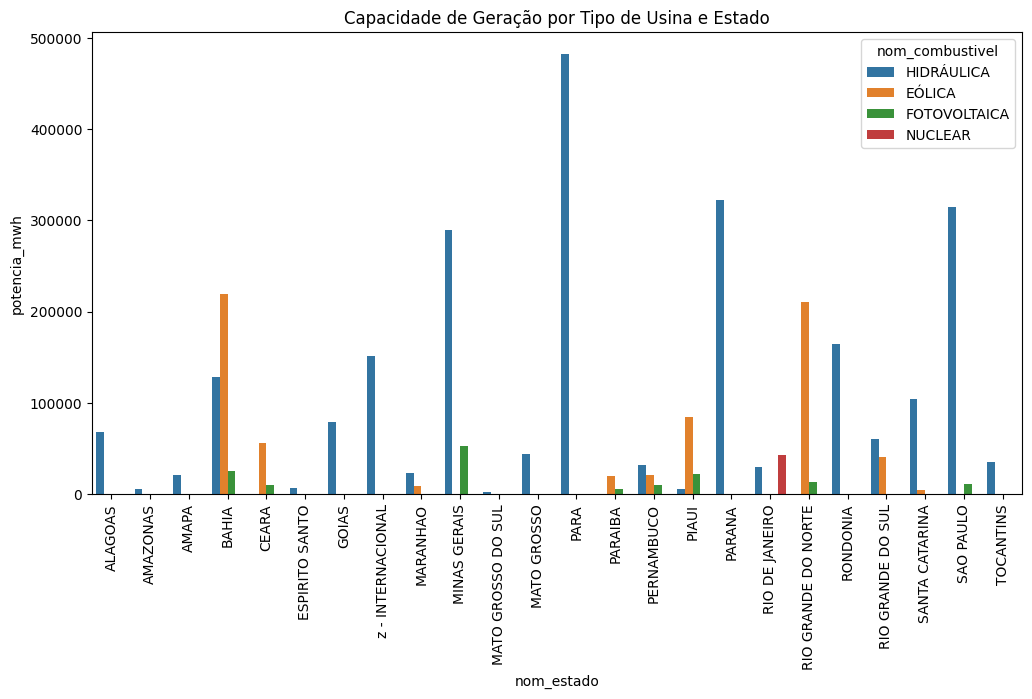

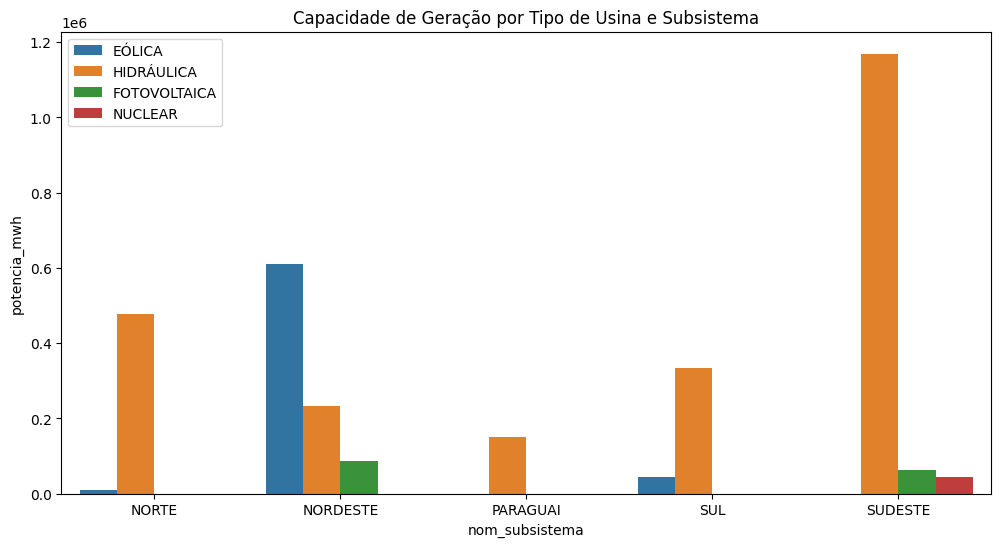

In [139]:
plt.figure(figsize=(12, 6))
plt.title('Capacidade de Geração por Tipo de Usina e Estado')
sns.barplot(
    data=df_capacidade_tipo_uf,
    x='nom_estado', y='potencia_mwh', hue='nom_combustivel',
    errorbar=None,
    
)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Capacidade de Geração por Tipo de Usina e Subsistema')
sns.barplot(
    data=df_capacidade_tipo_subsist,
    x='nom_subsistema', y='potencia_mwh', hue='nom_combustivel',
    errorbar=None,
)
plt.legend(loc='upper left')
plt.show()

## 4.2. Capacidade de geração por concessionária

In [140]:
top5_agentes = df_capacidade_tipo_agente.sort_values(
    'potencia_mwh', ascending=False
).groupby('nom_combustivel').head(5)

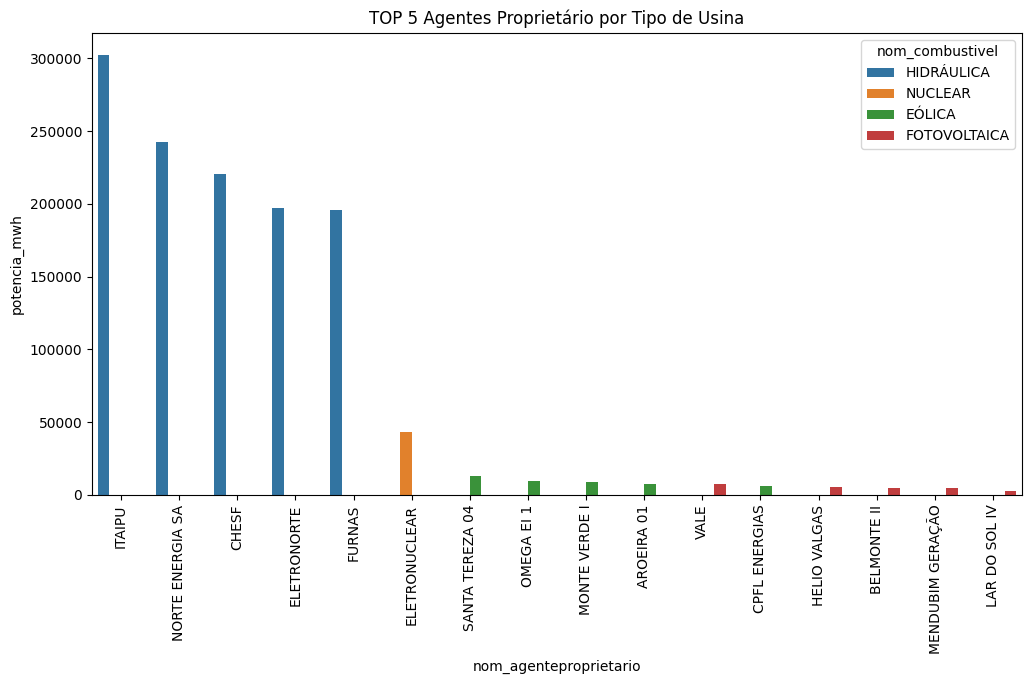

In [141]:
plt.figure(figsize=(12, 6))
plt.title('TOP 5 Agentes Proprietário por Tipo de Usina')
sns.barplot(
    data=top5_agentes,
    x='nom_agenteproprietario', y='potencia_mwh', hue='nom_combustivel',
    errorbar=None,
)
plt.xticks(rotation=90)
plt.show()

# 5. Salvando arquivos

In [142]:
df_capacidade_usina.to_parquet('../../data/processed/ONS/capacidade_usina.parquet')
df_capacidade_tipo_uf.to_parquet('../../data/processed/ONS/capacidade_tipo_uf.parquet')
df_capacidade_tipo_subsist.to_parquet('../../data/processed/ONS/capacidade_tipo_subsist.parquet')
df_capacidade_tipo_agente.to_parquet('../../data/processed/ONS/capacidade_tipo_agente.parquet')